<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=18JwHT8YDIJhm1Of7wvk65XdVfWxcg4af' width="200" />
<figcaption></figcaption></center>
</figure>

# ***Resolución de problemas directos e inversos de ecuaciones diferenciales mediante técnicas de deep learning***

**Practicantes:** Fernando Fêtis y Diego Olguín. 

**Supervisor:** Hugo Carrillo.




In [ ]:
#@title Librerías

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from mpl_toolkits.axes_grid1 import make_axes_locatable

import tqdm
import numpy as np
from scipy import stats
from scipy.interpolate import RegularGridInterpolator, interp1d
import random

import warnings

In [ ]:
#@title PINN code

class PDE:
    ''' Base class for PDE objects. '''
    
    
    def __init__(self, equation: callable, domain: dict, **kwargs):
        '''
        - equation: callable that takes 2 parameters (data [dict] and solution [tensor]) where data represents
            points in the domain and solution is the forward of the neural network.
        - domain: dict {var1: range1, var2: range2, ...} where var is a string with the name of the variable
            ('x', 'y', 't', etc.) and each range is a list [var_min, var_max].

        Keyword arguments:
        - boundary_condition [callable]: evaluate boundary condition in a point.
        - initial_condition [callable]: evaluate initial condition in a point.
        - known_solution [callable]: used to generate known points for inverse problems.
        - analytical_solution [callable]: returns the analytical solution(s) evaluated in a point.

        Example (1D equation (ODE)):
        - equation = lambda data, sol: tuple(d(sol[0], data['t']) - data['t'] , )  # u(t)_t - t = 0
        - domain = {'t': [0, 1]}  # t in [0, 1].
        - boundary = lambda data, sol: tuple(sol[0] - 5)  # u(t) - 5 = 0 at t=0.

        '''
        
        if 'initial_condition' in kwargs:
            assert 't' in domain, 'No temporal domain defined.'
        
        self.equation = equation
        self.domain = domain
        
        for key in kwargs:
            setattr(self, key, kwargs[key])

    def get_points(self,
                   size: int,
                   device: torch.device,
                   at_initial: bool = False,
                   on_boundary: bool = False,
                   requires_grad: bool = False):
        
        '''
        Return a dict {var1: tensor_1, var2: tensor_2, ...} where var is a string with the name
        of the variable ('x', 'y', 't', etc.) and tensor is a PyTorch Tensor uniformly sampled in the
        variable domain.

        - size: number of points to generate.
        - device: device where tensor are created.
        - at_initial: flag that indicates if the generated points are at t=0 (if the PDE has 't' variable).
        - on_boundary: flag that indicates if the generated points are in the boundary of the domain.
        - requires_grad: flag that indicates if the generated points retain graph.
        '''
                
        data = {key: torch.empty(size).uniform_(*self.domain[key])
                for key in self.domain}
         
        if at_initial:
            assert 't' in self.domain, 'PDE is not temporal.'
            data['t'].fill_(self.domain['t'][0])
        
        if on_boundary:
            spatial_vars = tuple(key for key in self.domain if key != 't')
            for n_sample in range(size):
                key = random.choice(spatial_vars)
                data[key][n_sample] = random.choice(self.domain[key])
        
        if requires_grad:
            for key in self.domain:
                data[key].requires_grad_()
        
        return data




class NeuralNetwork(nn.Module):
    '''Creates the PINN object that represents the neural network.'''

    def __init__(self,
                 n_variables: int,
                 n_output: int,
                 n_layers: int,
                 wide: int,
                 activation: nn.Module = nn.Tanh(),
                 dropout: float = 0.0,
                 bn: bool = False):
        
        '''
        Args:

            n_variables: Number of variables of the equation solutiones, must to be an integer.
            Consider that n_variables=1 corresponds to an ODE.

            n_outputs: Number of solutions that the net has to return, also considering the parameters
            that the network will aproximate in the inverse problem. A simple PDE problem like a Poisson
            equation will have one output. A system of PDE will have more than one output. For example in 
            in the problem -div(sigma*grad(u)) = f, with boundary conditions, the n_outputs has to be setted
            in 2 if the parameter sigma needs to be estimated like the unknown solution u.

            n_layers: Number of layers that the net will have.

            wide: Number of neurons per layer.

            activation: Function of nn.Module of Pytorch that acts as the activation funcion on each layer. To see
            all activation functions see:
            https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

            Defaults to nn.Tanh().

            dropout: Probability parameter of Dropout on each layer, has to be 0 <= p <= 1.

            bn: Indicates if Batch Normalization will be applied or not. False indicates not. Defaults False.
        '''

        super().__init__()
        
        # Internal attributes:
        self.conf_interval = None
        self.confidence = None
        self.n_output = n_output #n_output
        
        # Modules:
        self.inner_layers = nn.ModuleList([nn.Linear(n_variables if n == 0 else wide, wide)
                                           for n in range(n_layers - 1)])
        self.inner_layers_bn = nn.ModuleList([nn.BatchNorm1d(wide) if bn else nn.Identity()
                                              for n in range(n_layers - 1)])
        self.last_layer = nn.Linear(wide, n_output)
        self.activation = activation
        self.drop_p = dropout
        self.dropout = nn.Dropout(p=0.)

        # Initialization:
        def init_weights(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
        
        if self.activation in (nn.Tanh(), nn.Sigmoid()):
            self.apply(init_weights)
    
    
    def forward(self, data: dict):
        '''Forward method of nn.Module.

        Args:

            data: Dictionary whose keys are the variables of equation solution, with values torch.tensor
            corresponding to points to evaluate the network.

        Examples:

            >>> data = {'x': torch.tensor([1., 2.]), 't': torch.tensor([0.5, 0.8])}
            >>> data = {'x': torch.tensor([1., 2.]), 'y': torch.tensor([2., 3.]), 't': torch.tensor([0.5, 0.8])}
        '''
        input = torch.stack(list(data.values()), axis=1)
        
        for n_layer in range(len(self.inner_layers)):
            input = self.activation(self.inner_layers[n_layer](input))
            input = self.inner_layers_bn[n_layer](input)
            input = self.dropout(input)
        input = self.last_layer(input)
        
        return tuple(input[:, eq] for eq in range(self.n_output))
    
    
    def plot_pinn(self, pde: PDE, step: float = 1e-2):  
        '''Makes a plot of the result of training. It's a figure of nrows=number of equations
        of the pde and ncols=1 in the case of the pde has not analytical solution and ncols=3
        in the other case. If pde has analytical solution, the left plot will corresponds to
        the PINN simulation, the middle corresponds to the analytical solution plot and the 
        rigth to the error calculated as the absolute value of PINN solution minus analytic 
        solution. The result will change depending the dimension of the domain of the equation.

        1D equations (ODEs): makes a simple plot of u(t) versus t, the independent variable.
        2D equations: makes a contour plot with the first variable in x-axis and the second 
        variable in y-axis.  
        3D equations: returns an animation of the contour plots of the solution respect the
        first two variables, taking the last variable as time for the animation.

        The grid used to plot will be cubic grid of side length step.

        Equations of dimension 3 > cannot be plotted.

        Args:

            pde: Object of PDE class, has to be the same equation that PINN aproximates to solve.
            float: Side length of grid generate to plot. Defaults to 1e-2.

        '''
        self.eval()
        self.cpu()

        if len(pde.domain) == 2:

            data = [torch.arange(*domain, step) for domain in pde.domain.values()]
            grid_1, grid_2 = torch.meshgrid(*data, indexing='ij')
            
            var_names = list(pde.domain.keys())
            input = {var_names[0]: grid_1.flatten(), var_names[1]: grid_2.flatten()}
            u_pred = self(input)
            nrows = len(u_pred)
            
            if hasattr(pde, 'analytical_solution'):
                u_real = pde.analytical_solution(input)
                error = [torch.abs(real - pred) for (real, pred) in zip(u_real, u_pred)]
                
                plots = (u_pred, u_real, error)
                titles = 'PINN simulation', 'Analytical solution', 'Error'
                ncols = 3
            else:
                plots = (u_pred, )
                titles = 'PINN simulation',
                ncols = 1
                
            fig, ax = plt.subplots(nrows=nrows, ncols=ncols , figsize=(6*ncols, 5*nrows), squeeze=False)
            
            for eq in range(nrows):
                for plot in range(ncols):
                    
                    axis = ax[eq, plot] 
                                            
                    simulation = axis.contourf(grid_1, grid_2, plots[plot][eq].reshape_as(grid_1).detach(), cmap='Spectral')
                    plt.colorbar(simulation)
                    
                    axis.set_title(titles[plot],fontdict={'size': 16})
                    axis.set_xlabel(f'${var_names[0]}$')
                    axis.set_ylabel(f'${var_names[1]}$')

        elif len(pde.domain) == 3:

            if not 't' in pde.domain.keys():
                warnings.warn('The third variable will be used like a temporal variable')

            temp_var = list(pde.domain.keys())[-1]

            data = [torch.arange(*domain, step) for domain in pde.domain.values()]

            temp_data = data[-1].detach().numpy()

            grid_1, grid_2, grid_3 = torch.meshgrid(*data, indexing='ij')
            
            var_names = list(pde.domain.keys())
            input = {var_names[0]: grid_1.flatten(), var_names[1]: grid_2.flatten(), var_names[2]: grid_3.flatten()}
            u_pred = self(input)
            nrows = len(u_pred)
            
            if hasattr(pde, 'analytical_solution'):
                u_real = pde.analytical_solution(input)
                error = [torch.abs(real - pred) for (real, pred) in zip(u_real, u_pred)]
                
                plots = (u_pred, u_real, error)
                titles = 'PINN simulation', 'Analytical solution', 'Error'
                ncols = 3

            else:
                plots = (u_pred, )
                titles = 'PINN simulation',
                ncols = 1
                
            fig, ax = plt.subplots(nrows=nrows, ncols=ncols , figsize=(6*ncols, 5*nrows), squeeze=False)

            for eq in range(nrows):
                for plot in range(ncols):
            
                    ax[eq, plot].clear()           
                    simulation = ax[eq, plot].contourf(grid_1[:,:,0], grid_2[:,:,0], plots[plot][eq].reshape_as(grid_1)[:,:,0].detach(), cmap='Spectral')
                    fig.colorbar(simulation)
                    ax[eq, plot].set_title(titles[plot],fontdict={'size': 16})
                    ax[eq, plot].set_xlabel(f'${var_names[0]}$')
                    ax[eq, plot].set_ylabel(f'${var_names[1]}$')

            def _animate(i):

                for eq in range(nrows):
                    for plot in range(ncols):
                        ax[eq, plot].clear()            
                        simulation = ax[eq, plot].contourf(grid_1[:,:,i], 
                                                            grid_2[:,:,i], 
                                                            plots[plot][eq].reshape_as(grid_1)[:,:,i].detach(), 
                                                            cmap='Spectral')
                        
                        ax[eq, plot].set_title(titles[plot],fontdict={'size': 16})
                        ax[eq, plot].set_xlabel(f'${var_names[0]}$')
                        ax[eq, plot].set_ylabel(f'${var_names[1]}$')
                        

            ani = FuncAnimation(fig, _animate, frames=len(temp_data))
            ani.save('eq.gif', writer = 'pillow')

        elif len(pde.domain) == 1:
            
            var_name = list(pde.domain.keys())[0]
            input = {var_name: torch.arange(*pde.domain[var_name], step)}
            u_pred = self(input)[0].detach()

            plt.plot(input[var_name], u_pred, label='PINN')
            
            if hasattr(pde, 'analytical_solution'):
                u_real = pde.analytical_solution(input)[0]
                plt.plot(input[var_name], u_real, '--', alpha=0.6, linewidth=2, label='analytical solution')
            
            plt.xlabel(var_name); plt.ylabel(f'$u({var_name})$')
            plt.title('PINN simulation '); plt.legend()
            plt.grid(alpha=0.3, linestyle='--')

        else:
            raise Exception('PDE can have at most 3 variables to plot them.')

        plt.tight_layout()
        plt.show()

    def condifence_interval(self, data: dict):  
        '''Make a report of the confidence interval for a single point given as
        dictionary format equal as forward method format.

        Args:

            data: Dictionary whose keys are the variables of equation solution, with values torch.tensor
            corresponding to points to evaluate the network.

        Prints for each output in the net the confidence interval computed in the 
        training epoch, if was indicated, as follows:

        Confidence of confidence setted in training, defaults 95% or 0.95

        Output number:

        Predicted value: net estimation
        Mean value: mean value of the epochs given to confidence interval calculation.
        Lower value: lower value of the confidence interval computed in training part.
        Upper value: upper value of the confidence interval computed in training part.

        Example (for a equation of dimension 2, with 2 equations and 2 outputs):

        >>> data = {'x': torch.tensor([1.]), 't': torch.tensor([.5])}
        >>> pinn.condifence_interval(data)
            
        >>> Confidence of 95.0%:

            Output number 1:

            Predicted value: 1.46025550365448
            Mean value: 1.4011306762695312
            Lower value: 1.1304807662963867
            Upper value: 1.6717805862426758

            Output number 2:

            Predicted value: 1.1432186365127563
            Mean value: 1.07851243019104
            Lower value: 0.8631584048271179
            Upper value: 1.293866515159607

        '''
        assert self.conf_interval is not None, 'First compute confidence interval.'
        
        input_inter = torch.stack(list(data.values()), axis=1).numpy()[0]
        pred_value = self(data)

        n_eqs = len(pred_value)

        mean_value, lower_value, upper_value = self.conf_interval

        print("Confidence of "+str(self.confidence*100)+"% for:")
        print()

        for i in range(n_eqs):
            mv, lv, uv = mean_value[i], lower_value[i], upper_value[i]
            m, L, U = mv(input_inter), lv(input_inter), uv(input_inter)

            print("Output number "+str(i+1)+":")
            print()
            print(f'Predicted value: {pred_value[i].item()}')
            print(f'Mean value: {m[0]}')
            print(f'Lower value: {L[0]}')
            print(f'Upper value: {U[0]}')
            print()


    def plot_confidence(self, pde: PDE, step: float = 1e-2):
        '''Plots the confidence interval of the solution. Will be a plot of ncols=number of outputs 
        of the network.

        1D equations (ODEs): Plot the solution predicted by the net (best epoch) in orange, the 
        mean solution (of last epochs in confidence interval computation) in blue and the lower and upper
        interval like yellow fill between.
        2D equations: Plot the mean solution like a surface, and the lower and upper likes a surface with 
        little alpha for transparency.

        The grid of the plot will be equidistant with step equal to step.

        Args:

            pde: Object of PDE class, has to be the same equation that PINN aproximates to solve.
            float: Side length of grid generate to plot. Defaults to 1e-2.
        '''
        assert self.conf_interval is not None, 'First compute confidence interval.'

        self.eval()
        self.cpu()

        if len(pde.domain) == 2:

            data = [torch.arange(*domain, step) for domain in pde.domain.values()]
            grid_1, grid_2 = torch.meshgrid(*data, indexing='ij')
            
            var_names = list(pde.domain.keys())
            input = {var_names[0]: grid_1.flatten(), var_names[1]: grid_2.flatten()}
            u_pred = self(input)
            ncols = len(u_pred)
            
            M, L, U = self.conf_interval
            g1, g2 = grid_1.detach().numpy(), grid_2.detach().numpy()
                
            fig, ax = plt.subplots(nrows=1, ncols=ncols , figsize=(6*ncols, 5), subplot_kw={'projection': '3d'}, squeeze=False)
            
            for i in range(ncols):
                m, l, u = M[i], L[i], U[i]
                ax[0,i].plot_surface(g1, g2, m((g1, g2)), cmap = "Spectral")
                ax[0,i].plot_surface(g1, g2, l((g1, g2)), alpha = 0.2)
                ax[0,i].plot_surface(g1, g2, u((g1, g2)), alpha = 0.2)
                ax[0,i].set_xlabel(f'${var_names[0]}$')
                ax[0,i].set_ylabel(f'${var_names[1]}$')
                ax[0,i].set_title('u '+str(i+1))

            plt.show()


        elif len(pde.domain) == 1:

            var_name = list(pde.domain.keys())[0]
            dom_esp = torch.arange(*pde.domain[var_name], step)
            dom_det = dom_esp.detach()
            input = {var_name: dom_esp}
            u_pred = self(input)
            ncols = len(u_pred)

            M, L, U = self.conf_interval
            fig, ax = plt.subplots(nrows=1, ncols=ncols , figsize=(6*ncols, 5))

            if ncols == 1:
                m, l, u = M[0], L[0], U[0]
                ax.plot(dom_det, m(dom_det), label='Mean solution')
                ax.fill_between(dom_det, l(dom_det), u(dom_det), label='CI '+str(self.confidence*100)+'%', color='yellow', alpha=0.5)
                ax.plot(input[var_name], u_pred[0].detach().numpy(), label='PINN')

            else:
                for i in range(ncols):
                    m, l, u = M[i], L[i], U[i]
                    ax.plot(dom_det, m(dom_det), label='Mean solution')
                    ax.fill_between(dom_det, l(dom_det), u(dom_det), label='CI '+str(self.confidence*100)+'%', color='yellow', alpha=0.5)
                    ax.plot(input[var_name], u_pred[i].detach().numpy(), label='PINN')        
            
            plt.xlabel(var_name); plt.ylabel(f'$u({var_name})$')
            plt.title('PINN simulation '); plt.legend()
            plt.grid(alpha=0.3, linestyle='--')


def d(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

class Trainer:

    '''Class to train a PINN for a specific PDE object.'''
    
    def __init__(self,
                 pde: PDE,
                 pinn: NeuralNetwork,
                 optimizer: optim.Optimizer,
                 scheduler: optim.lr_scheduler = None,
                 pcgrad: bool = False):

        '''
        - pde: PDE object that will be used to train the network.
        - pinn: neural network used to learn the solution(s) of the PDE.
        - optimizer: PyTorch optimizer object associated to pinn parameters.
        - scheduler: PyTorch scheduler object associated to the optimizer. This manages the learning rate.
        - pcgrad: flag that indicates if the optimization will be done with pcgrad method.
        '''
        
        self.pde = pde
        self.pinn = pinn
        self.optimizer = optimizer  #! PCGrad(optimizer) if pcgrad else optimizer
        self.pcgrad = pcgrad
        self.scheduler = scheduler
        
        # Default:
        self.loss_fn = nn.MSELoss()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.CI = {'confidence': 0.95, 'epochs': 10, 'inter_points': 50, 'dropout': 0.01}

        # Training statistics:
        self.losses = {'physics': [], 'boundary': [], 'initial': [], 'known': [], 'total': []}
        self.best_state = {'state': None, 'epoch': 0, 'loss': float('inf')}
    
    
    def _generate_data(self, samples: dict):
        '''
        returns a dict {'data_type': (data_points, data_target)} where data_type represents each loss used
        in the training. This protected method is called by the public train method.
        
        - samples: dict {'data_type': num_samples} where num_samples are the number of pairs (data, target)
            generated for each data_type.
        '''
        
        data_physics = self.pde.get_points(samples['physics'], device=self.device, requires_grad=True)
        target_physics = torch.zeros(samples['physics'], device=self.device)
        
        if samples.get('boundary', 0) > 0 and hasattr(self.pde, 'boundary_condition'):
            data_boundary = self.pde.get_points(samples['boundary'], device=self.device, on_boundary=True, requires_grad=True)
            target_boundary = torch.zeros(samples['boundary'], device=self.device)
        else:
            data_boundary, target_boundary = None, None
            
        if samples.get('initial', 0) > 0 and hasattr(self.pde, 'initial_condition'):
            data_initial = self.pde.get_points(samples['initial'], device=self.device, at_initial=True, requires_grad=True)
            target_initial = torch.zeros(samples['initial'], device=self.device)
        else:
            data_initial, target_initial = None, None
        
        if samples.get('known', 0) > 0 and hasattr(self.pde, 'known_solution'):
            data_known = self.pde.get_points(samples['known'], device=self.device, requires_grad=True)
            target_known = self.pde.known_solution(data_known)
        else:
            data_known, target_known = None, None
        
        return {'physics': (data_physics, target_physics),
                'boundary': (data_boundary, target_boundary),
                'initial': (data_initial, target_initial),
                'known': (data_known, target_known)}
            
    
    def _calc_loss(self, data: dict, weights: dict, save_loss: bool = False):
        '''
        calculate the loss associated to data generated in the training method. For each data type, the
        solution(s) of the PDE are computed by the PINN forward. Then, the PINN output is passed through the
        PDE and the loss is calculated as the approximation error (compared with zero).

        - data: data points generated by the protected _generate_data method.
        - weights: dict {'loss_type': weight} where weight [int] represent the ponderator of the specific loss
            for the total loss calculation.
        - save_loss: flag that indicates if the calculated losses must be stored in the losses class attribute.
            by default is False since 2nd-order optimizers need to call this method several times in each iteration.
        '''
                        
        data_physics, target_physics = data['physics']
        data_boundary, target_boundary = data['boundary']
        data_initial, target_initial = data['initial']
        data_known, target_known = data['known']
        
        losses = dict(zip('physics boundary initial known'.split(), torch.zeros(4)))

        if data_physics is not None:
            u_physics = self.pinn(data_physics)
            eq_physics = self.pde.equation(data_physics, u_physics)
            losses['physics'] = sum([self.loss_fn(eq, target_physics) for eq in eq_physics])
        
        if data_boundary is not None:
            u_boundary = self.pinn(data_boundary)
            eq_boundary = self.pde.boundary_condition(data_boundary, u_boundary)
            losses['boundary'] = sum([self.loss_fn(eq, target_boundary) for eq in eq_boundary])
        
        if data_initial is not None:
            u_initial = self.pinn(data_initial)
            eq_initial = self.pde.initial_condition(data_initial, u_initial)
            losses['initial'] = sum([self.loss_fn(eq, target_initial) for eq in eq_initial])
        
        if data_known is not None:
            u_known = self.pinn(data_known)
            losses['known'] = sum([self.loss_fn(u_known[eq], target_known[eq])
                                   for eq in range(self.pinn.n_output)
                                   if target_known[eq] is not None])
        
        total_loss = sum([weights[loss] * losses[loss] for loss in 'physics boundary initial known'.split()])
        
        if save_loss:
            for loss in 'physics boundary initial known'.split():
                self.losses[loss].append(weights[loss] * losses[loss].item())
            self.losses['total'].append(total_loss.item())
        
        return list(losses.values()) if self.pcgrad else total_loss
    
    
    def plot_loss(self, first_epoch: int = 1, last_epoch: int = None):
        '''
        show the recorded losses during training.

        - first_epoch: indicates from which epoch the loss will be plotted. This to avoid scale problem
            due to abrupt loss descending at the beginning.
        - last_epoch: indicates the last loss epoch that will be shown. None indicates that loss will
            be plotted until the last recorded epoch.
        '''
        
        if last_epoch is None:
            last_epoch = len(self.losses['total'])
        epochs = torch.arange(first_epoch, last_epoch + 1, 1)
        
        fig = plt.figure(figsize=(12, 5))
        for loss in 'physics boundary initial known total'.split():
            linewidth, alpha = (2, 1) if loss == 'total' else (1, 0.7)
            plot_data = self.losses[loss][first_epoch - 1: last_epoch]
            if max(plot_data) != 0:
                plt.plot(epochs, plot_data, label=loss, linewidth=linewidth, alpha=alpha)
        
        plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Training loss')
        plt.grid(alpha=0.3, linestyle='--'); plt.legend()
        plt.tight_layout()
        plt.show()
    
    
    def train(self,
              epochs: int,
              samples: dict = {'physics': 500, 'boundary': 500, 'initial': 500, 'known': 500},
              weights: dict = {'physics': 1, 'boundary': 1, 'initial': 1, 'known': 10},
              early_stopping: int = False,
              calculate_confidence: bool = False,
              confidence: float = 0.95, 
              conf_epochs: int = 10,
              inter_points: int = 50,
              p_dropout: float = 0.01):
        
        '''
        Train the neural network to learn the solution of the PDE. This method use _generate_data and
        _calc_loss methods. train_data variable must be moved into the training loop in order to sample
        different data in each iteration.

        - epochs: number of epoch for training.
        - samples: indicates the amount of data generated for training.
        - weights: indicates the ponderator of each loss type when calculating total loss.
        - early_stopping: indicates the number of epoch waiting to improve the loss. False indicates that
            the training will be done until the end.
        - calculate_confidence: flag that indicates if the confidence intervals must be calculated.
        - confidence: indicates the level of confidence calculated in the confidence intervals.
        - conf_epochs: number of aditional training epochs used for calculate the confidence intervals.
        - inter_points:
        - p_dropout:
        '''
        
        assert samples.get('physics', 0) > 0, 'Points where verify PDE are needed.'
        
        def closure():
            '''
            Inner method to make the optimization. It is called by the optimizer. Furthermore, this format is 
            strictly necesary for 2-nd order PyTorch optimizers.
            '''

            self.optimizer.zero_grad()
            loss = self._calc_loss(train_data, weights)
            
            if self.pcgrad:
                self.optimizer.pc_backward(loss)
                return sum(loss)
            else:
                loss.backward()
                return loss
            
        # Training:
        try:
            bar_format = '{l_bar}{bar}| epoch {n_fmt} of {total_fmt} ({rate_fmt}) | loss: {postfix} | training time: {elapsed}'
            epoch_counter = tqdm.trange(1, epochs + 1, unit='epochs', bar_format=bar_format, miniters=1)
            self.pinn.train()
            patience, loss = 0, 0
            
            train_data = self._generate_data(samples)
            
            for epoch in epoch_counter:
                
                # Optimization:
                self.optimizer.step(closure)
                if self.scheduler is not None:
                    self.scheduler.step()
                
                loss = self._calc_loss(train_data, weights, save_loss=True)
                loss = sum(loss).item() if self.pcgrad else loss.item()

                if torch.isnan(torch.Tensor([loss])):
                    print('NaN loss. Net must to be restarted and execute the training again.')
                    break
                
                epoch_counter.set_postfix_str(f'{loss:.4f}')

                # Early stopping and best model:
                if loss < self.best_state['loss']:
                    patience = 0
                    self.best_state['state'] = self.pinn.state_dict().copy()
                    self.best_state['epoch'] = epoch
                    self.best_state['loss'] = loss
                else:
                    patience += 1
                    if early_stopping and patience == early_stopping:
                        print(f'Early stopping in the {epoch}.')
                        break
        
        # Post-training:
        except KeyboardInterrupt:
            last_valid_epoch = len(self.losses['total'])
            for loss in 'physics boundary initial known'.split():
                self.losses[loss] = self.losses[loss][:last_valid_epoch]
            print(f'Training interrupted at epoch {last_valid_epoch}.')
            
        if calculate_confidence:
            self.pinn.dropout.p = self.pinn.drop_p
            self.pinn.confidence = confidence
            self.CI = {'confidence': confidence, 'epochs': conf_epochs, 'inter_points': inter_points, 'dropout': p_dropout}
            self._confidence_intervals(train_data, weights, samples)
            self.pinn.dropout.p = 0
    
    
    def _confidence_intervals(self, train_data, weights, samples):
        '''
        Computes the confidence interval with epochs given previously, as follows:

        If N > 1 are the number of epochs given to compute the confidence interval, then the
        mean solution is

        hat_u = mean(u_1, ..., n_N)

        where u_i corresponds to the discretization of the net in inter_pints by dimension, for each 
        output of the net.

        Then, s is the unbiased standard deviation of the sample, T is a t-Student distribution with
        N-1 freedom degrees and c it's a real number satisfying

        Probability(-c <= T <= c) = confidence

        With this the lower bound of the confidence interval is calculated as 

        L = hat_u - s*c/sqrt(N)

        and the upper bound as

        U = hat_u + s*c/sqrt(N)

        For last, the tensors of u_hat, L and U will be interpolated in the domain with Scipy interpolators.
        For ODEs, interp1d will be used and for the others RegularGridInterpolator. This functions will
        be saved in pinn.conf_interval.

        Args:

            train_data: Data to train, with collocation, boundary, initial and known if are needed.
            weigths: Weights for the looses.
            samples: Dictionary with quantity of samples per data, as physics (collocation), boundary, 
            initial and known.
        '''

        def closure():
            self.optimizer.zero_grad()
            loss = self._calc_loss(train_data, weights)
            
            if self.pcgrad:
                self.optimizer.pc_backward(loss)
                return sum(loss)
            else:
                loss.backward()
                return loss
        
        dom_lins, conf_points = [], []

        for domain in self.pde.domain.values():
            dom_lins.append(torch.linspace(*domain, self.CI['inter_points']))
            conf_points.append(self.CI['inter_points'])

        grid = torch.meshgrid(dom_lins, indexing='ij')
        input = {}

        keys = list(self.pde.domain.keys())
        for i in range(len(dom_lins)):
            input[keys[i]] = grid[i].flatten()

        u_conf = torch.zeros(size = [self.CI['epochs']] + [self.pinn.n_output] + conf_points)

        try:
            bar_format = '{l_bar}{bar}| epoch {n_fmt} of {total_fmt} ({rate_fmt}) | loss: {postfix} | training time: {elapsed}'
            epoch_counter = tqdm.trange(1, self.CI['epochs'] + 1, unit=' epochs', bar_format=bar_format, miniters=1)
            self.pinn.train()
            
            train_data = self._generate_data(samples)
            
            for epoch in epoch_counter:
                
                # Optimization:
                self.optimizer.step(closure)
                if self.scheduler is not None:
                    self.scheduler.step()
                
                loss = self._calc_loss(train_data, weights, save_loss=True)
                loss = sum(loss).item() if self.pcgrad else loss.item()

                if torch.isnan(torch.Tensor([loss])):
                    print('NaN loss. Net must to be restarted and execute the training again.')
                    break
                
                epoch_counter.set_postfix_str(f'{loss:.4f}')

                u_conf[epoch-1] = torch.stack(self.pinn(input)).reshape(tuple([self.pinn.n_output] + conf_points))
        
        # Post-training:
        except KeyboardInterrupt:
            last_valid_epoch = len(self.losses['total'])
            for loss in 'physics boundary initial known'.split():
                self.losses[loss] = self.losses[loss][:last_valid_epoch]
            print(f'Training interrupted at epoch {last_valid_epoch}.')

        M = u_conf.mean(dim=0).detach().numpy()
        S = u_conf.std(dim=0, unbiased=True).detach().numpy()
        c = stats.t.ppf((1 + self.CI['confidence']) / 2., self.CI['epochs'] - 1)

        conf = S*c/(np.sqrt(self.CI['epochs']))

        lower_int = M - conf
        upper_int = M + conf

        M_inter, Lower_inter, Upper_inter = [], [], []

        if len(self.pde.domain) == 1:
            for i in range(self.pinn.n_output):
                M_inter.append(interp1d(dom_lins[0], M[i]))
                Lower_inter.append(interp1d(dom_lins[0], lower_int[i]))
                Upper_inter.append(interp1d(dom_lins[0], upper_int[i]))

        else:
            for i in range(self.pinn.n_output):
                M_inter.append(RegularGridInterpolator(dom_lins, M[i]))
                Lower_inter.append(RegularGridInterpolator(dom_lins, lower_int[i]))
                Upper_inter.append(RegularGridInterpolator(dom_lins, upper_int[i]))

        self.pinn.conf_interval = (M_inter, Lower_inter, Upper_inter)

In [ ]:
def equation(data, solution):
  u = solution[0]
  t = data['t']

  u_t = d(u, t)
  eq = u_t - torch.exp(-u*t)
  return (eq, )

def initial_condition(data, solution):
  u = solution[0]
  t = data['t']

  ic = u 
  return (ic, )

100%|██████████| epoch 5 of 5 ( 7.39epochs/s) | loss: , 0.0027 | training time: 00:00
100%|██████████| epoch 30 of 30 ( 6.14 epochs/s) | loss: , 0.0018 | training time: 00:04


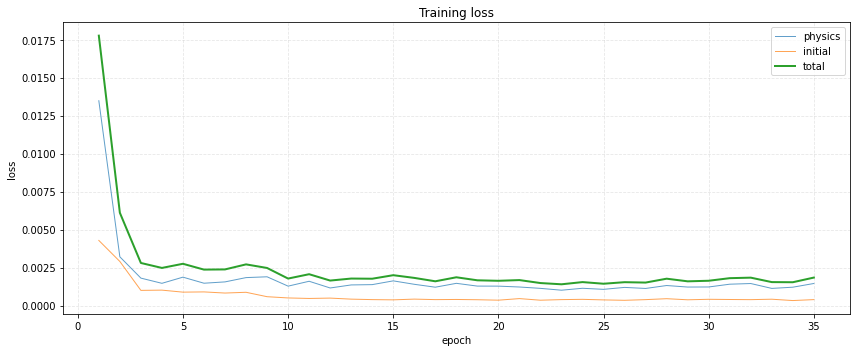

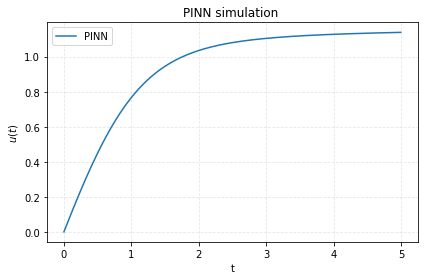

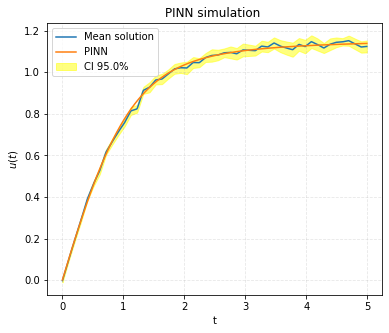

In [ ]:
pde = PDE(equation=equation,
          domain={'t':[0, 5]},
          initial_condition=initial_condition)

net = NeuralNetwork(n_variables=1,
                    n_output=1,
                    n_layers=2,
                    wide=100,
                    dropout=0.05)

optimizer = optim.LBFGS(net.parameters(), line_search_fn='strong_wolfe')
trainer = Trainer(pde, net, optimizer)

trainer.train(epochs=5, calculate_confidence=True, conf_epochs=30)  
trainer.plot_loss()
net.plot_pinn(pde)
net.plot_confidence(pde)

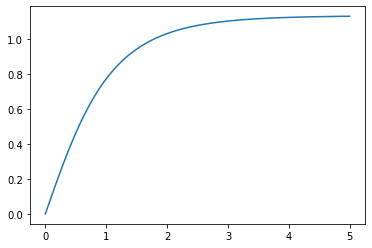

In [ ]:
from scipy.integrate import solve_ivp 

def f(t, u):
  return np.exp(-u*t)

u0 = 0

sol = solve_ivp(f, [0, 5], [u0], rtol=10e-14, atol=10e-14)
t, u = sol['t'], sol['y'][0]
plt.plot(t, u)
plt.show()

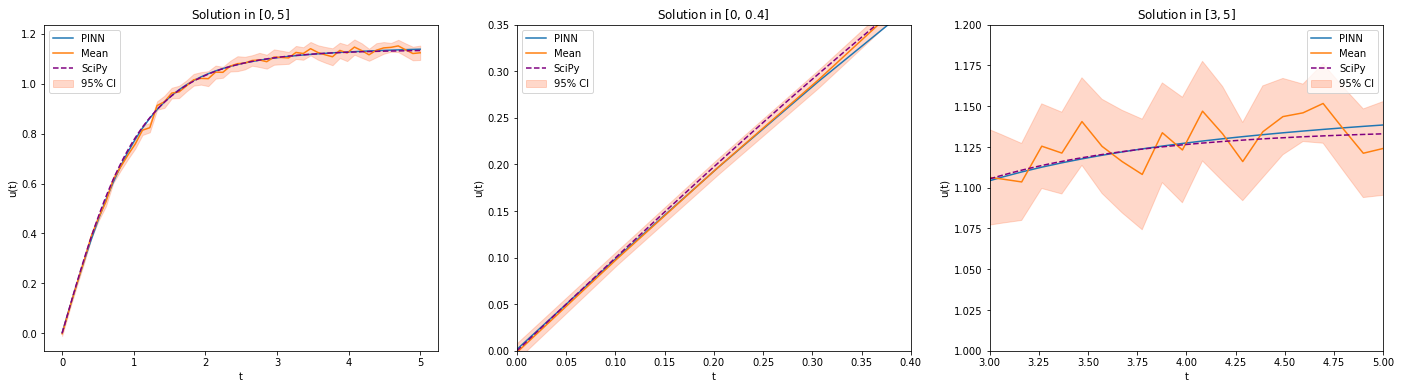

In [ ]:
m, l, up = net.conf_interval
M, L, U = m[0], l[0], up[0]

t_plot = torch.linspace(0, 5, 50).unsqueeze(1)
t_nump = t_plot.numpy().reshape((len(t_plot)))
data = {'t': t_plot}
u_pred = net(data)[0].detach()
M_plot, L_plot, U_plot = M(t_nump), L(t_nump), U(t_nump)

fig, ax = plt.subplots(1, 3, figsize=(24,6))

ax[0].plot(t_plot, u_pred, label="PINN")
ax[0].plot(t_nump, M_plot, label="Mean")
ax[0].fill_between(t_nump, L_plot, U_plot, label="95% CI", color="coral", alpha=0.3)
ax[0].plot(t, u, '--', label="SciPy", color="purple")
ax[0].legend()
ax[0].set_xlabel("t")
ax[0].set_ylabel("u(t)")
ax[0].set_title(r"Solution in $[0, 5]$")

ax[1].plot(t_plot, u_pred, label="PINN")
ax[1].plot(t_nump, M_plot, label="Mean")
ax[1].fill_between(t_nump, L_plot, U_plot, label="95% CI", color="coral", alpha=0.3)
ax[1].plot(t, u, '--', label="SciPy", color="purple")
ax[1].legend()
ax[1].set_xlim(0., 0.4)
ax[1].set_ylim(0., 0.35)
ax[1].set_xlabel("t")
ax[1].set_ylabel("u(t)")
ax[1].set_title(r"Solution in $[0, \, 0.4]$")


ax[2].plot(t_plot, u_pred, label="PINN")
ax[2].plot(t_nump, M_plot, label="Mean")
ax[2].fill_between(t_nump, L_plot, U_plot, label="95% CI", color="coral", alpha=0.3)
ax[2].plot(t, u, '--', label="SciPy", color="purple")
ax[2].legend()
ax[2].set_xlim(3, 5)
ax[2].set_ylim(1, 1.2)
ax[2].set_xlabel("t")
ax[2].set_ylabel("u(t)")
ax[2].set_title(r"Solution in $[3, 5]$")

plt.savefig("UQ.pdf")

plt.show()

In [ ]:
def equation(data, solution):
  u = solution[0]
  x, t = data['x'], data['t']

  u_t = d(u, t)
  u_x = d(u, x)
  u_xx = d(u_x, x)

  eq = u_t - u_xx - (x + 2*torch.cos(x))
  return (eq, )

def initial_condition(data, solution):
  u = solution[0]
  x, t = data['x'], data['t']

  ic = u - 2*torch.cos(x)
  return (ic, )

def boundary_condition(data, solution):
  u = solution[0]
  x, t = data['x'], data['t']

  bc = u - (2*torch.cos(x) + t*x)
  return (bc, )


def analytical_solution(data):
  x, t = data['x'], data['t']

  sol = 2*torch.cos(x) + t*x
  return (sol, )

100%|██████████| epoch 20 of 20 ( 2.16epochs/s) | loss: , 0.0001 | training time: 00:09
100%|██████████| epoch 30 of 30 ( 3.00 epochs/s) | loss: , 0.6936 | training time: 00:10


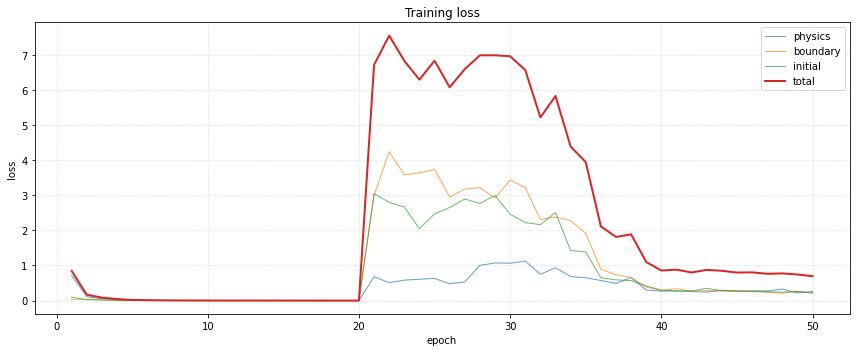

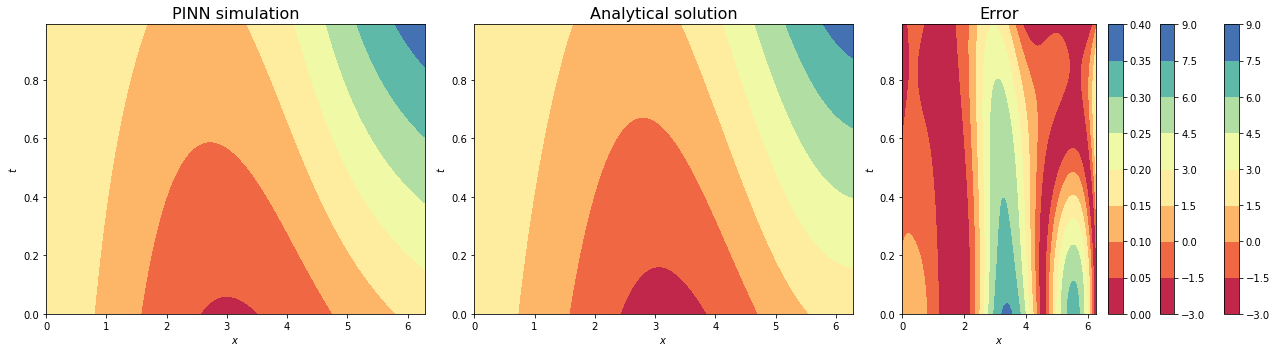

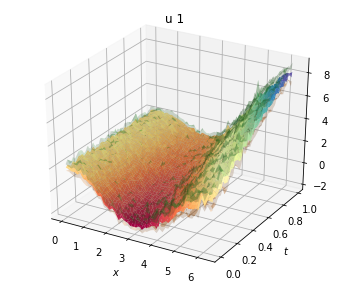

In [ ]:
pde = PDE(equation=equation,
          domain={'x':[0, 2*torch.pi], 't':[0, 1]},
          initial_condition=initial_condition,
          boundary_condition=boundary_condition,
          analytical_solution=analytical_solution)

net = NeuralNetwork(n_variables=2,
                    n_output=1,
                    n_layers=3,
                    wide=100,
                    dropout=0.01)

optimizer = optim.LBFGS(net.parameters(), line_search_fn='strong_wolfe')
trainer = Trainer(pde, net, optimizer)

trainer.train(epochs=20, calculate_confidence=True, conf_epochs=30)  
trainer.plot_loss()
net.plot_pinn(pde)
net.plot_confidence(pde)

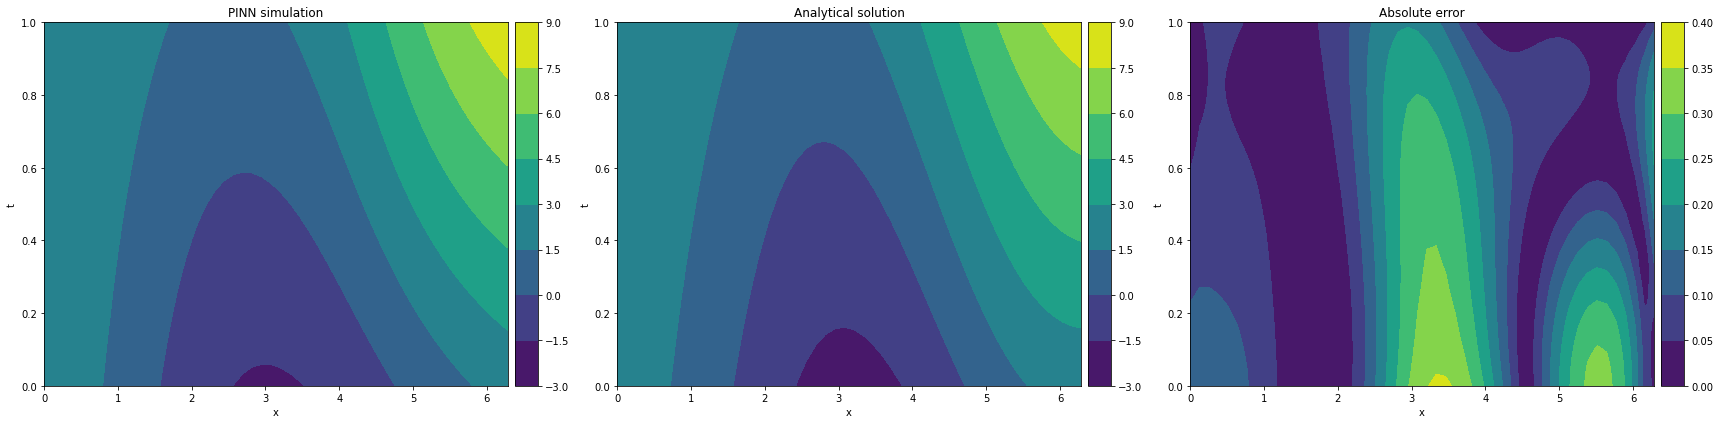

In [ ]:
m, l, up = net.conf_interval
M, L, U = m[0], l[0], up[0]

x_plot, t_plot = torch.linspace(0, 2*torch.pi, 50), torch.linspace(0, 1, 50)
x_grid, t_grid = torch.meshgrid(x_plot, t_plot, indexing='ij')
x_nump, t_nump = x_plot.numpy(), t_plot.numpy()
data = {'x': x_grid.flatten(), 't': t_grid.flatten()}

u_pred = net(data)[0].detach().reshape_as(x_grid)
u_sol = analytical_solution(data)[0].detach().reshape_as(x_grid)
error = abs(u_pred - u_sol)

fig, ax = plt.subplots(1, 3, figsize=(24,6))

c = ax[0].contourf(x_grid, t_grid, u_pred)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(c, cax=cax, orientation='vertical')
ax[0].set_xlabel("x")
ax[0].set_ylabel("t")
ax[0].set_title("PINN simulation")

c = ax[1].contourf(x_grid, t_grid, u_sol)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(c, cax=cax, orientation='vertical')
ax[1].set_xlabel("x")
ax[1].set_ylabel("t")
ax[1].set_title("Analytical solution")

c = ax[2].contourf(x_grid, t_grid, error)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(c, cax=cax, orientation='vertical')
ax[2].set_xlabel("x")
ax[2].set_ylabel("t")
ax[2].set_title("Absolute error")

plt.savefig("UQHeat1.pdf")
plt.tight_layout()

plt.show()

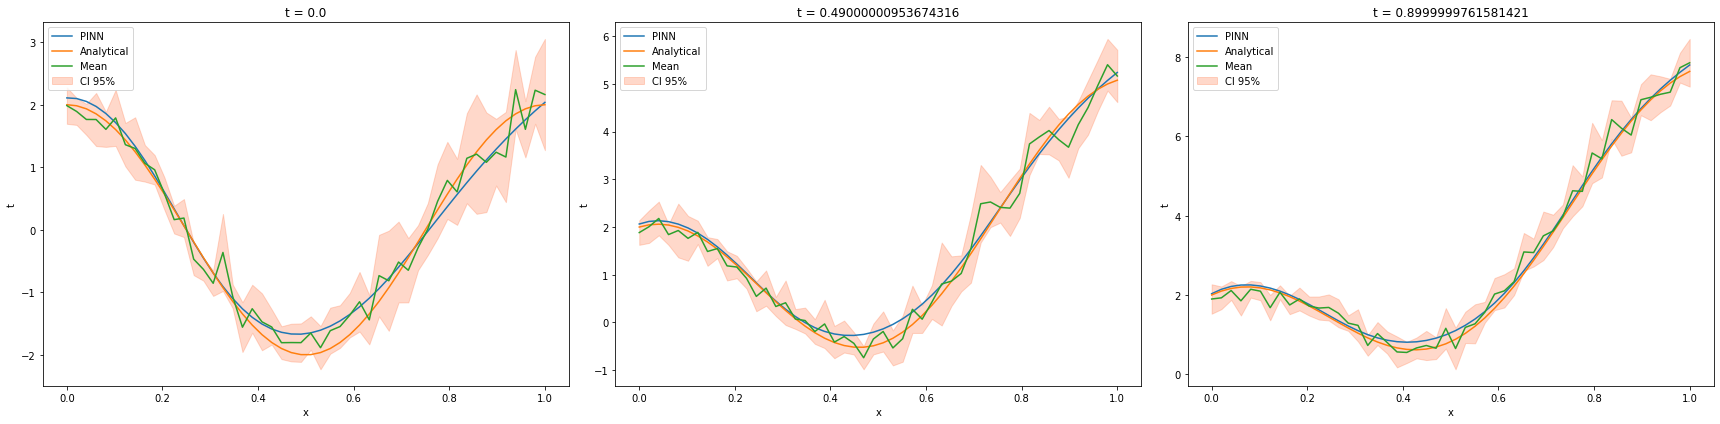

In [ ]:
m, l, up = net.conf_interval
M, L, U = m[0], l[0], up[0]

x_plot, t_plot = torch.linspace(0, 2*torch.pi, 50), torch.linspace(0, 1, 50)
x_grid, t_grid = torch.meshgrid(x_plot, t_plot, indexing='ij')
x_nump, t_nump = x_plot.numpy(), t_plot.numpy()
data_int = (x_grid.numpy(), t_grid.numpy())
data = {'x': x_grid.flatten(), 't': t_grid.flatten()}

CI_mean, CI_lower, CI_upper = M(data_int), L(data_int), U(data_int)

u_pred = net(data)[0].detach().reshape_as(x_grid)
u_sol = analytical_solution(data)[0].detach().reshape_as(x_grid)
error = abs(u_pred - u_sol)

t_show = [0, 24, 44]

fig, ax = plt.subplots(1, 3, figsize=(24,6))

i = t_show[0]
ax[0].plot(t_plot, u_pred[:,i], label="PINN")
ax[0].plot(t_plot, u_sol[:,i], label="Analytical")
ax[0].plot(t_nump, CI_mean[:,i], label="Mean")
ax[0].fill_between(t_nump, CI_lower[:,i], CI_upper[:,i], color="coral", alpha=0.3, label="CI 95%")
ax[0].set_xlabel("x")
ax[0].set_ylabel("t")
ax[0].legend()
ax[0].set_title(f"t = {round(t_nump[i], 2)}")

i = t_show[1]
ax[1].plot(t_plot, u_pred[:,i], label="PINN")
ax[1].plot(t_plot, u_sol[:,i], label="Analytical")
ax[1].plot(t_nump, CI_mean[:,i], label="Mean")
ax[1].fill_between(t_nump, CI_lower[:,i], CI_upper[:,i], color="coral", alpha=0.3, label="CI 95%")
ax[1].set_xlabel("x")
ax[1].set_ylabel("t")
ax[1].legend()
ax[1].set_title(f"t = {round(t_nump[i], 2)}")

i = t_show[2]
ax[2].plot(t_plot, u_pred[:,i], label="PINN")
ax[2].plot(t_plot, u_sol[:,i], label="Analytical")
ax[2].plot(t_nump, CI_mean[:,i], label="Mean")
ax[2].fill_between(t_nump, CI_lower[:,i], CI_upper[:,i], color="coral", alpha=0.3, label="CI 95%")
ax[2].set_xlabel("x")
ax[2].set_ylabel("t")
ax[2].legend()
ax[2].set_title(f"t = {round(t_nump[i], 2)}")

plt.savefig("UQHeat2.pdf")
plt.tight_layout()

plt.show()